In [26]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [38]:
import math
import numpy as np
from matplotlib import pyplot as plt
import scipy as sp
import network_dynamics as ndyn

# Simulation #1 - Fully connected, Gaussian Kernel

We're looking to see that global inhibition is working, that eventually firing rates plateau when there is no longer external input.

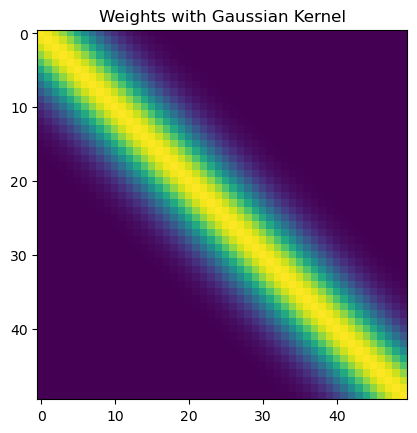

In [42]:
network = ndyn.Network(N=50, T=20)
ndyn.plot_weight_matrix(network, 'Weights with Gaussian Kernel')

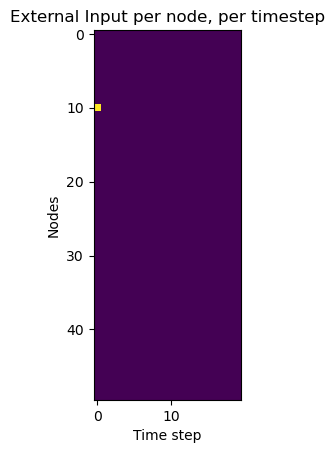

In [29]:
external_input = np.zeros((network.N, network.T))
external_input[10, 0] = 1

ndyn.plot_external_input(external_input)

In [31]:
solution = network.simulate(external_input, ndyn.sp_solve_ivp, lambda sol: sol.y)
print(solution)

  message: The solver successfully reached the end of the integration interval.
  success: True
   status: 0
        t: [ 0  1 ... 18 19]
        y: [[ 0.000e+00  1.389e-02 ...  3.511e-06  2.995e-06]
            [ 0.000e+00  2.002e-02 ...  4.359e-06  3.718e-06]
            ...
            [ 0.000e+00  3.391e-11 ...  3.818e-12  3.257e-12]
            [ 0.000e+00  1.241e-11 ...  1.734e-12  1.479e-12]]
      sol: None
 t_events: None
 y_events: None
     nfev: 158
     njev: 0
      nlu: 0


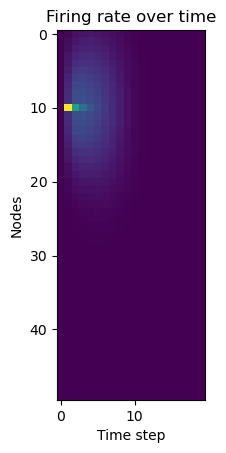

In [32]:
ndyn.plot_firing_rate(network, "Firing rate over time")

# Simulation #2 - "Flashing" external input with strong recurrent weight

We're looking to see that

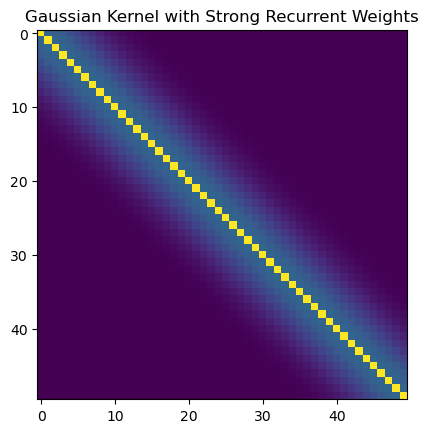

In [34]:
np.fill_diagonal(network.W, 3)
ndyn.plot_weight_matrix(network, 'Gaussian Kernel with Strong Recurrent Weights')

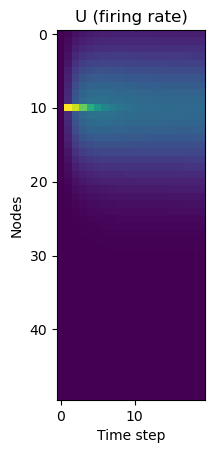

In [35]:
network.simulate(external_input, ndyn.sp_solve_ivp, lambda sol: sol.y)
ndyn.plot_firing_rate(network)

# Simulation 3 - Constant Stimulus with Gaussian Function

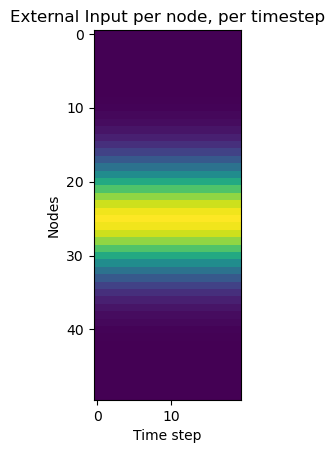

In [62]:
network = ndyn.Network(50, 20)
external_input = ndyn.get_diff_matrix(network.N, 25)
external_input = ndyn.gaussian_func(external_input)
external_input = np.tile(external_input, (1, network.T))
ndyn.plot_external_input(external_input)

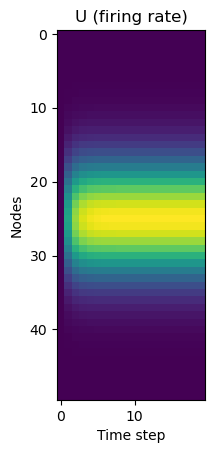

In [63]:
network.simulate(external_input, ndyn.sp_solve_ivp, lambda sol: sol.y)
ndyn.plot_firing_rate(network)

# Simulation - Periodic Stimulus
"To mimic real situations more precisely, such as when the stimulus is the orientation or moving direction of objects, we restrict the stimulus in the simulation to be a periodical variable. More exactly, we consider stimulus x (and so does the preferred stimulus of neurons) in the range (−π, π ], with x = θ and x = 2π + θ being the same. Under this condition, the steady states of the network will no longer have the exact gaussian form as in equation 2.4. However, provided that the value of a is not too large, say, a < π as considered here, the bell shape of steady states still holds, as confirmed by the simulation. With the periodic condition, the form of recurrent interactions is adjusted..." (Wu & Amari 2005)

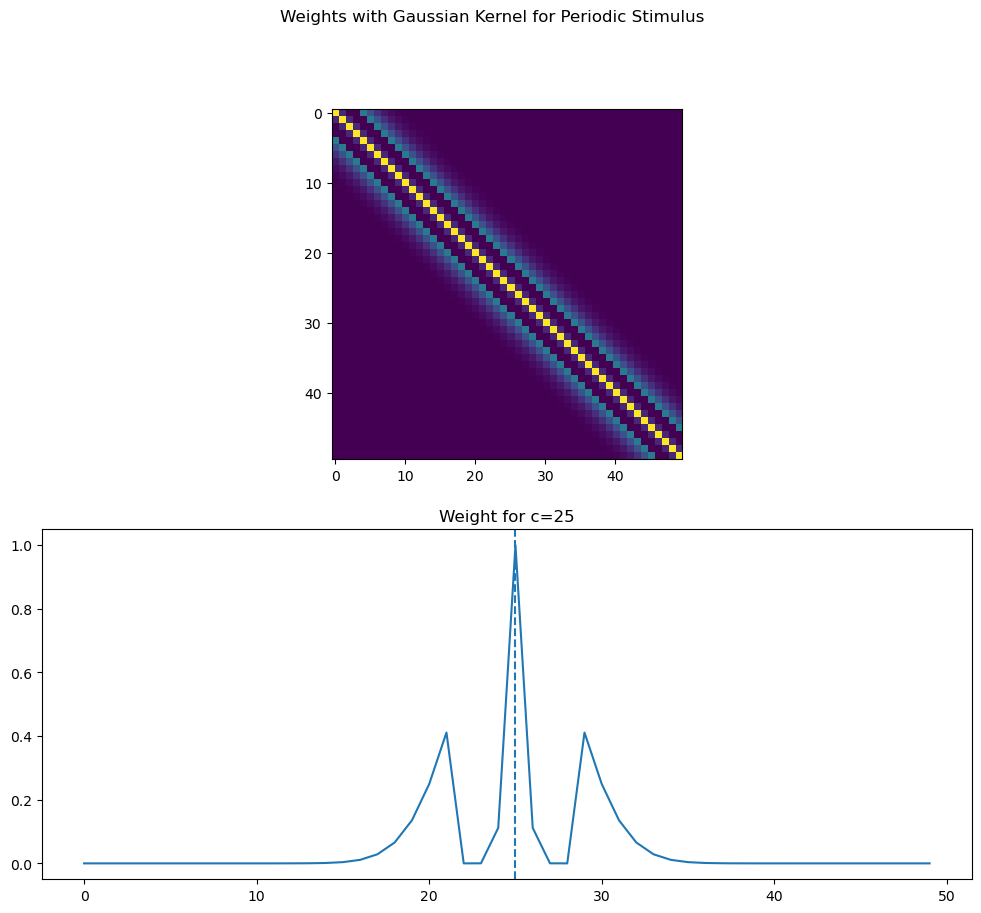

In [97]:
# Weight matrix for periodic stimulus
def weights_for_periodic_stimulus(N, a:int = 0.2):
    diff_matrix = ndyn.get_diff_matrix(N)

    gt_pi = diff_matrix > np.pi
    lte_pi = diff_matrix <= np.pi
    diff_matrix[gt_pi] = np.exp(-np.power(diff_matrix[gt_pi], 2) / (2 * np.power(a, 2)))
    diff_matrix[lte_pi] = np.exp(-np.power(2 * np.pi * diff_matrix[lte_pi], 2) / (2 * np.power(a, 2)))
    return diff_matrix

network = ndyn.Network(N=50, T=20, W_func=weights_for_periodic_stimulus, W_kwargs={'a': 3})
ndyn.plot_weight(network, 25)

In [91]:
# External input with moving perturbation

In [ ]:
num_nodes = 50
num_time_steps = 20

w = np.zeros((num_nodes, num_nodes))
width = 2
for r in range(1, num_nodes + 1):
    for c in range(1, num_nodes + 1):
        if r - c <= math.pi:
            w[r - 1][c - 1] = math.exp(-math.pow(r - c, 2) / (2 * width * math.pow(width, 2)))
        else:
            w[r - 1][c - 1] = math.exp(-math.pow(2 * math.pi - math.fabs(r - c), 2) / (2 * width * math.pow(width, 2)))

In [ ]:
def get_input_with_bump(neurons_to_bump: list, timestep_of_bump, N, T, a, gamma = 0.1, bump_h=2):
    external_input_with_bumps = np.tile(np.arange(N)[:, np.newaxis], (1, T))
    external_input_with_bumps = gamma * np.exp(-(external_input_with_bumps**2) / (2 * a**2))
    # TODO need to add moving bump through timesteps
    return external_input_with_bumps

external_input = get_input_with_bump(neurons_to_bump=[0, 25, 49], timestep_of_bump=3, N=num_nodes, T=num_time_steps, a=width)
# print(external_input)
plot_external_input(external_input, num_time_steps)

In [ ]:
tau = 5
mu = 5
U = np.zeros((num_nodes, num_time_steps))
Oc = U[:, 0]

solution = sp.integrate.solve_ivp(nn_ode, [0, num_time_steps - 1], U[:, 0], t_eval=np.arange(0, num_time_steps), args=(w, external_input, tau, mu))
print(solution)
plt.title("Firing rate over time")
plt.xlabel("Time step")
plt.plot(solution.t, solution.y.T);

In [ ]:
# TODOs
# use contour plot -- DONE
# critical value of recurrent weight . if large enough, the network can hold non zero response after external input goes away -- DONE
# generate moving input -- WIP
# h = v * t (v is speed) -- WIP
# add noise from 2020 bioxiv paper
